### Devide the Hamiltonian by N 

Lets think differently. What I can suspect that with H = 2/N (sz)^2 - 2 (sx), this equation has each term of the equations of order N. When this N which is basically the spin we are investigating corresponding to LMG hilbert space spin size, gets bigger and so as the matrix and its elements also. This creates some agitation in numerical computation processes. 
For solve this I can consider rathers smaller valued elements by deviding the hamiltonian by N. This will make no change the dimension of the matrix but reduce this values of matrix elements of hamiltonian. Thus we can get the same set of eigenstates with eigen values devided by N.
This makes life easier. With this suppressed normalisation we can ease up computational pressure. 
Right now we are focussed to evaluate IPR which depends only on the eigenstates.


In [11]:
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator, jmat,tensor, sigmax, sigmay, sigmaz, qeye, mesolve
from qutip.floquet import floquet_modes
from scipy.special import j0, jn_zeros

def floquet_modes_phtr(H, T, args=None, parallel=False, sort=False, U=None):
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, options=options)
    
    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

def get_hamiltonians_singlepartham(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                      # kacNorm
    H0 = kn * sz **2 / N
    H1 = 2 * sx / N
    return H0,H1
    
def drive_exact_sten(t, args):
    h0 = args['h0']
    w = args['omega']
    h = args['h']
    return h0 + h * np.cos(w * t)

def floq_evolv_exact_sten_singlepartham(args):
    w = args['omega']
    T = 2 * np.pi/w
    N = args['N']
    H0, H1 = get_hamiltonians_singlepartham(N)
    H = [H0,[H1,drive_exact_sten]]
    f_modes_0, f_energies = floquet_modes_phtr(H, T, args=args)
    return [w, f_modes_0, f_energies]

print('definition done!')

definition done!


In [10]:
#!rm phase_transition_singlepartham*
!rm file_phasetran_ham_single.txt


import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.special import jn_zeros, j0
import math, tqdm
from qutip import Options
#from functions_needed import*
import h5py, time

freezing_pts = jn_zeros(0, 5)
start = time.time()

#Ns = [10,20,30,50, 100,150]
#ostp = [1e4,1e5,1e6,1e7,1e11, 1e14]

Ns = [200]
ostp = [1e8]

ws = np.exp(np.linspace(np.log(1), np.log(50), 100))
h0 = np.pi/2

nth = 0
frz_nth = 0

if __name__ == '__main__':
    nprocs = 10    
    
    for nn,N in tqdm.tqdm(enumerate(Ns)):
        start1 = time.time()
        opts = Options(nsteps = ostp[nn])        

        params = [{'h0':h0, 'h': w/4 * freezing_pts[frz_nth], 'omega':w, 'N':N, 'opts':opts} for w in ws]
        p = Pool(processes = nprocs)  

        data = np.array(p.map(floq_evolv_exact_sten_singlepartham,params))
        w_f = np.array(data[:,0])
        evec_ff = np.array(data[:,1])
        phs_f = np.array(data[:,2])

        evec_f = np.array([np.array([np.array(evec_ff[j][i])[:,0].real for i in range(int(2*N+1))]) for j in range(len(ws))])

        evals_single_path = np.zeros(len(ws))
        iprmat_single_path = np.zeros(len(ws))
        iprmat = np.zeros((len(ws),2*N+1))

        sx = jmat(N,"x")
        en, st = sx.eigenstates()

        for xx,w in enumerate(ws):
            #Get the previous Floquet Eigensystem
            if xx == 0:
                evals_prev = phs_f[xx].real
                evecs_prev = evec_f[xx]
            else:
                evals_prev = phs_f[xx-1].real
                evecs_prev = evec_f[xx-1]

            #Sort the Floquet states of this itertaion accordingly to orthonormality with the previous ones
            evals_curr = phs_f[xx]
            evecs_curr = evec_f[xx]
            #t = np.copy(evecs_curr)
            condition = np.abs(np.around(evecs_prev.T.conj() @ evecs_curr, 1))   
            evals_curr = evals_curr[np.argmax(condition, axis=1)]
            evecs_curr = evecs_curr[:,np.argmax(condition, axis=1)]

            evals_single_path[xx] = evals_curr[nth]

            f_states = evec_f[xx]
            iprmat[xx,:] = [np.sum([np.abs(Qobj(state).overlap(sx_ev))**4 for sx_ev in st], axis=-1) for state in f_states]
            iprmat_single_path[xx] = iprmat[xx,:][nth]

            # save the data
        filename = 'phase_transition_singleparthamN_bigger_nsteps_' + str(N) +'_.hdf5'

        with h5py.File(filename, 'w') as hf:
            hf.create_dataset('ws', np.shape(ws), data=ws)
            hf.create_dataset('iprmat_single_path', np.shape(iprmat_single_path), data=iprmat_single_path)
            hf.create_dataset('evals_single_path', np.shape(evals_single_path), data=evals_single_path)
            hf.attrs['N'] = N
            hf.attrs['dc'] = h0
        print('time taken %5.1f  minutes !'% ((time.time()-start1)/60))
    print('\n\n\n Code Run Complete!! \n\n TOTAL TIME TAKEN : %5.1f  minutes !' %((time.time()-start)/60))

0it [00:00, ?it/s]/tmp/ipykernel_4098/513131984.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(p.map(floq_evolv_exact_sten_singlepartham,params))
1it [53:22, 3202.26s/it]

time taken  53.4  minutes !



 Code Run Complete!! 

 TOTAL TIME TAKEN :  53.4  minutes !


In [1]:
!ls phase_transition_singlepartham* > file_phasetran_ham_single.txt
!cat file_phasetran_ham_single.txt

phase_transition_singleparthamN_bigger_nsteps_100_.hdf5
phase_transition_singleparthamN_bigger_nsteps_10_.hdf5
phase_transition_singleparthamN_bigger_nsteps_200_.hdf5
phase_transition_singleparthamN_bigger_nsteps_20_.hdf5
phase_transition_singleparthamN_bigger_nsteps_30_.hdf5
phase_transition_singleparthamN_bigger_nsteps_350_.hdf5
phase_transition_singleparthamN_bigger_nsteps_50_.hdf5


number of data files  5
phase_transition_singleparthamN_bigger_nsteps_10_.hdf5
phase_transition_singleparthamN_bigger_nsteps_20_.hdf5
phase_transition_singleparthamN_bigger_nsteps_30_.hdf5
phase_transition_singleparthamN_bigger_nsteps_50_.hdf5
phase_transition_singleparthamN_bigger_nsteps_100_.hdf5


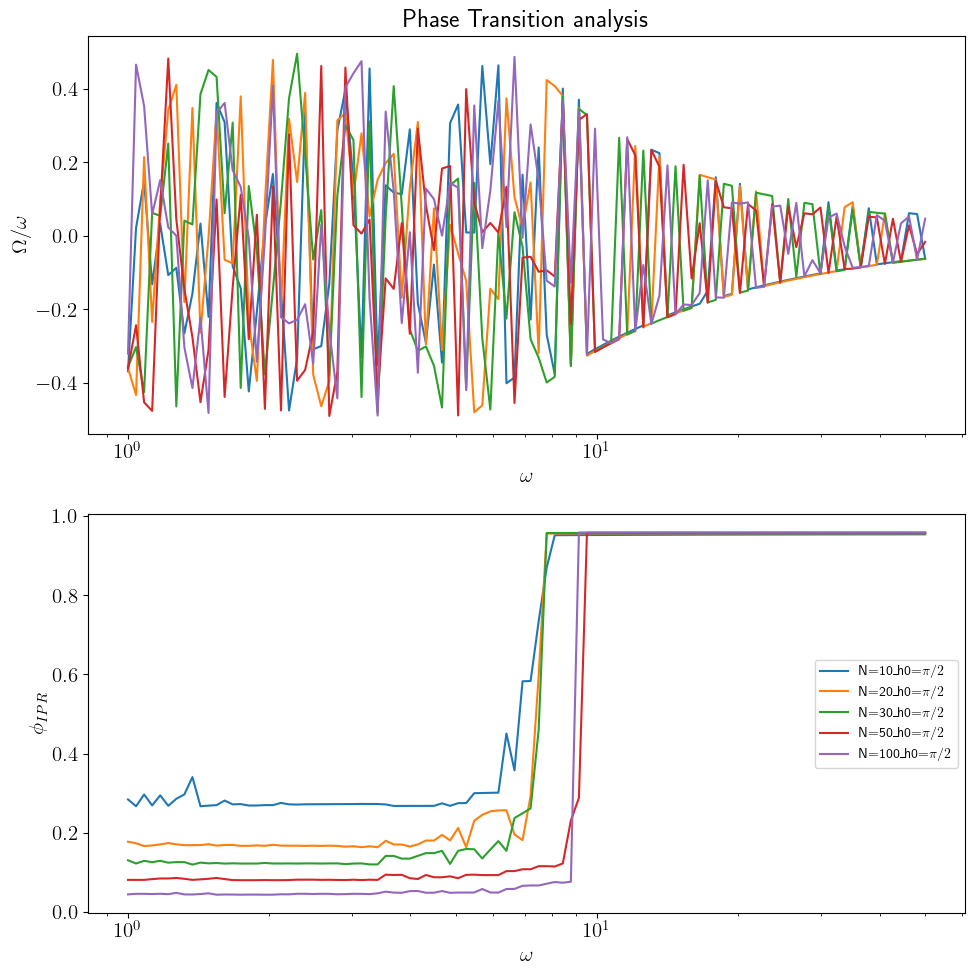

CPU times: user 1.01 s, sys: 332 ms, total: 1.34 s
Wall time: 945 ms


In [3]:
%%time
import matplotlib.pyplot as plt
import h5py

plt.rcParams.update({ "figure.figsize": (10, 10),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15, "font.sans-serif": ["Computer Modern"]})

h0v0 = r"$\sqrt{3}$"
h0v1 = r"$\sqrt{3}/2^{\frac{N}{4}}$"
h0v2 = r"$\sqrt{3}/2^{\frac{N}{2}}$"
h0v3 = r"$\sqrt{3}/2^{\frac{N}{6}}$"

h00s = h0v0

with open("file_phasetran_ham_single.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    
    fig, axs = plt.subplots(2, 1)
    
    print('number of data files ',x)
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, 'r') as f:
            print(filename)    
            ws = f['ws'][()]
            evals_single_path = f['evals_single_path'][()]
            iprmat_single_path = f['iprmat_single_path'][()]
            N = f.attrs['N']
            
            lbl = 'N=' + str(N)

            axs[0].plot(ws, evals_single_path/ws, label= N)
            axs[0].set_ylabel(r"$\Omega/\omega$")
            axs[0].set_xlabel(r"$\omega$")
            axs[0].set_xscale('log')
            #axs[0].set_title(fr'Phase dynamics : $N = {N}$')
            axs[0].set_title(fr'Phase Transition analysis')


            lbl = 'N=' + str(N) + '_h0=' + r"$\pi /2$"
            axs[1].plot(ws, iprmat_single_path, label = lbl)
            axs[1].set_ylabel(r"$\phi_{{IPR}}$")
            axs[1].set_xlabel(r"$\omega$")
            #axs[1].set_ylim(0.9,1.1)
            #axs[1].set_xlim(4, 15)
            axs[1].set_xscale('log')
            axs[1].legend(loc = 5,fontsize= 10)
            
    figname= "phase_dynam_frz_pt=N.jpeg" 
    

    plt.tight_layout()
    #fig.legend(loc = 5,fontsize= 10)
    #plt.savefig(figname,dpi=1200)
    plt.show()

number of data files  5
phase_transition_singleparthamN_bigger_nsteps_10_.hdf5
phase_transition_singleparthamN_bigger_nsteps_20_.hdf5
phase_transition_singleparthamN_bigger_nsteps_30_.hdf5
phase_transition_singleparthamN_bigger_nsteps_50_.hdf5
phase_transition_singleparthamN_bigger_nsteps_100_.hdf5


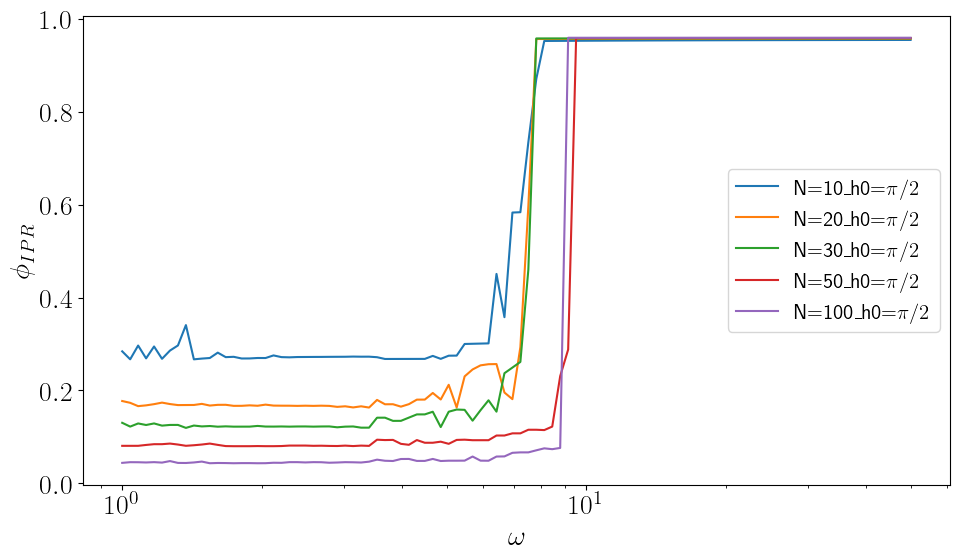

CPU times: user 2.39 s, sys: 2.02 s, total: 4.41 s
Wall time: 6.37 s


In [1]:
%%time
import matplotlib.pyplot as plt
import h5py

plt.rcParams.update({ "figure.figsize": (10, 6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 20, "font.sans-serif": ["Computer Modern"]})

h0v0 = r"$\sqrt{3}$"
h0v1 = r"$\sqrt{3}/2^{\frac{N}{4}}$"
h0v2 = r"$\sqrt{3}/2^{\frac{N}{2}}$"
h0v3 = r"$\sqrt{3}/2^{\frac{N}{6}}$"

h00s = h0v0

with open("file_phasetran_ham_single.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    
    print('number of data files ',x)
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, 'r') as f:
            print(filename)    
            ws = f['ws'][()]
            evals_single_path = f['evals_single_path'][()]
            iprmat_single_path = f['iprmat_single_path'][()]
            N = f.attrs['N']
            
            lbl = 'N=' + str(N)
            #plt.title(fr'Phase Transition: LMG')


            lbl = 'N=' + str(N) + '_h0=' + r"$\pi /2$"
            plt.plot(ws, iprmat_single_path, label = lbl)
            plt.ylabel(r"$\phi_{{IPR}}$")
            plt.xlabel(r"$\omega$")
            plt.xscale('log')
            plt.legend(loc = 5,fontsize= 10)
            
    figname1= "phase_dynam_frz_pt=N.jpeg" 
    figname = 'phase_transition_LMG.jpeg'

    plt.tight_layout()
    plt.legend(loc = 5,fontsize= 15)
    plt.savefig(figname,dpi=800)
    plt.show()

### plot it differently

number of data files  5
phase_transition_singleparthamN_bigger_nsteps_10_.hdf5
phase_transition_singleparthamN_bigger_nsteps_20_.hdf5
phase_transition_singleparthamN_bigger_nsteps_30_.hdf5
phase_transition_singleparthamN_bigger_nsteps_50_.hdf5
phase_transition_singleparthamN_bigger_nsteps_100_.hdf5


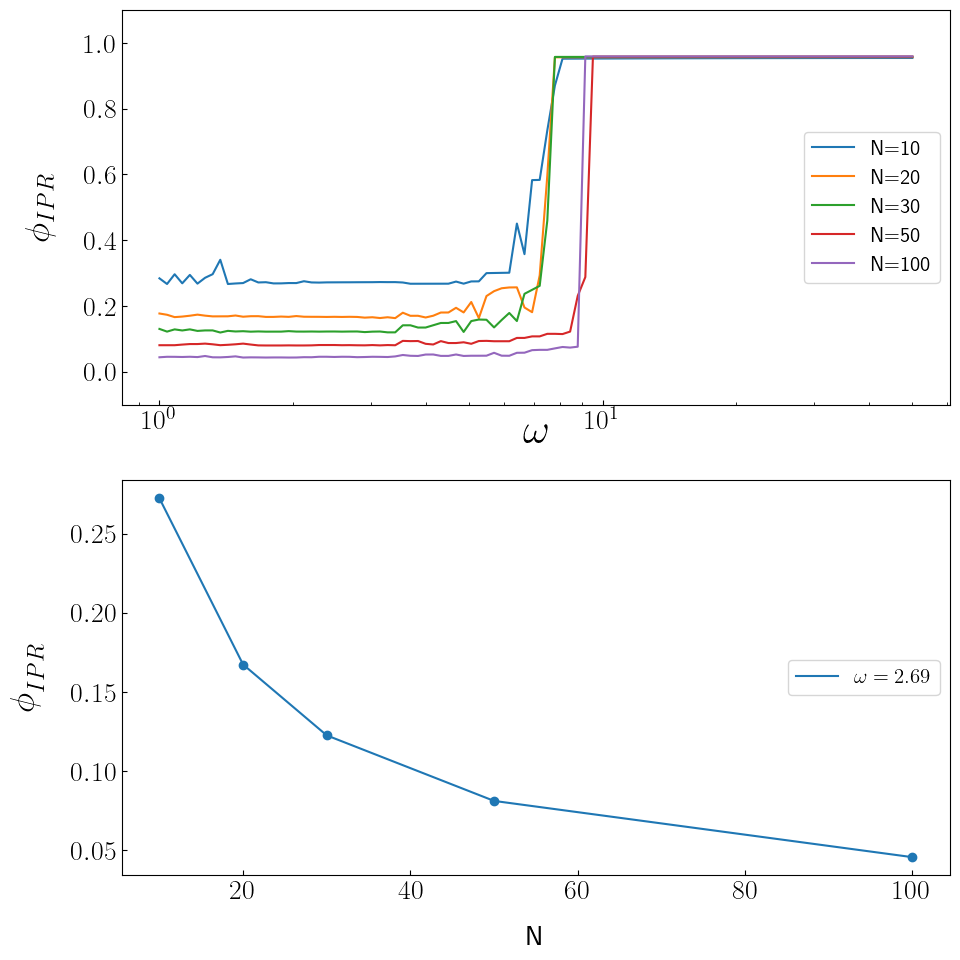

CPU times: user 2.21 s, sys: 894 ms, total: 3.11 s
Wall time: 4.66 s


In [43]:
%%time
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit

plt.rcParams.update({ "figure.figsize": (10, 10),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 20, "font.sans-serif": ["Computer Modern"]})

def func(x, a, b):
    #return a * x**(c)
    return a * x +b


h0v0 = r"$\sqrt{3}$"
h0v1 = r"$\sqrt{3}/2^{\frac{N}{4}}$"
h0v2 = r"$\sqrt{3}/2^{\frac{N}{2}}$"
h0v3 = r"$\sqrt{3}/2^{\frac{N}{6}}$"

h00s = h0v0
point = 25
ww, iprmm, NN = [], [], []
fig, axs = plt.subplots(2, 1)
with open("file_phasetran_ham_single.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    
    print('number of data files ',x)
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, 'r') as f:
            print(filename)    
            ws = f['ws'][()]
            evals_single_path = f['evals_single_path'][()]
            iprmat_single_path = f['iprmat_single_path'][()]
            N = f.attrs['N']
            
            lbl = 'N=' + str(N)
            #plt.title(fr'Phase Transition: LMG')


            lbl = 'N=' + str(N)
            axs[0].plot(ws, iprmat_single_path, label = lbl)
            axs[0].xaxis.set_label_coords(0.05, -0.025)
            axs[0].set_ylabel(r"$\phi_{{\tiny IPR}}$", fontsize = 25, labelpad=20)
            axs[0].set_xlabel(r"$\omega$", fontsize = 30, labelpad=20)
            axs[0].set_xscale('log')
            axs[0].tick_params(which='both', axis="x", direction="in")
            axs[0].tick_params(which='both', axis="y", direction="in")
            axs[0].legend(loc = 5,fontsize= 15)
            axs[0].set_ylim(-.1,1.1)
            
            
            NN.append(N)
            ww.append(ws[point])
            iprmm.append(iprmat_single_path[point])
            
    figname1= "phase_dynam_frz_pt=N.jpeg" 
    figname = 'phase_transition_LMG_N.jpeg'
    
    #params, covs = curve_fit(func, NN, iprmm)
    #a,b = params[0], params[1]
    #yfit = a * NN + b
    
    
    
    
    axs[1].scatter(NN, iprmm)
    lbl3 = r"$\omega = $" + str(ww[0])
    lbl3 = r"$\omega = {:2.2f}$".format(ww[0])
    axs[1].plot(NN, iprmm, label=lbl3)
    #axs[1].text(0.05,0.05,r"$\phi^{}_{{IPR}}$", rotation = 90)
    axs[1].set_ylabel(r"$\phi^{}_{{\tiny IPR}}$", fontsize = 25, labelpad=20)
    axs[1].tick_params(which='both', axis="x", direction="in")
    axs[1].tick_params(which='both', axis="y", direction="in")
    axs[1].set_xlabel("N", fontsize = 20, labelpad=15)
    #axs[1].set_xscale('log')
    axs[1].legend(loc = 'upper right')
    
    #axs[1].plot(NN, yfit, label = 'fit_data')
    
    plt.tight_layout()
    plt.legend(loc = 5,fontsize= 15)
    plt.savefig(figname,dpi=800)
    plt.show()

## Phase Transition : Ising Model

In [118]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve 
from qutip.floquet import floquet_modes
from scipy.special import j0, jn_zeros
freezing_pts = jn_zeros(0, 5)

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_floquet_isingfermion(args, **kwargs):
    k = args['k']
    T = 2 * np.pi/args['omega']
    sx = sigmax()
    sz = sigmaz()
    
    # construct the hamiltonian
    H0 = np.sin(k) * sx + np.cos(k) * sz
    H1 = sz
    H = [H0,[H1,drive]]    
    
    return floquet_modes(H, T, args, **kwargs)

def get_iprvals_exact(w, k, **kwargs):
    params = {'h0':0.0, 'h':freezing_pts[0]*w/2.0, 'k':k,'omega':w}
    
    f_states, f_energies = get_floquet_isingfermion(params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

CPU times: user 235 µs, sys: 16 µs, total: 251 µs
Wall time: 257 µs


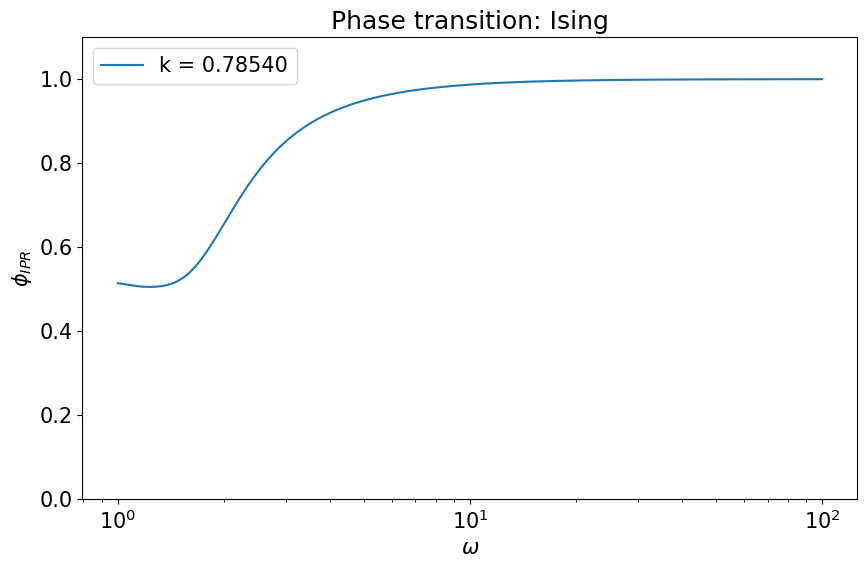

CPU times: user 4.19 s, sys: 640 ms, total: 4.83 s
Wall time: 4.3 s


In [121]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
import traceback

plt.rcParams.update({"figure.figsize": (10, 6),"text.usetex": False,"font.size": 15})
freezing_pts = jn_zeros(0, 5)

omegas = np.exp(np.linspace(np.log(1), np.log(100), 500))
delta = 1e-4
ks = [np.pi/4]

for k in ks:
    iprvals_exact = np.array([get_iprvals_exact(w, k, sort=True) for w in omegas])
    plt.plot(omegas, iprvals_exact[:,0], label = fr"k = {k:1.5f}")

plt.title(fr'Phase transition: Ising' )
plt.xscale('log')
plt.xlabel(r'$\omega$')
plt.ylabel(r"$\phi_{{IPR}}$")
plt.legend()
plt.ylim(0.0,1.1)
plt.savefig('phase_transition_ising.jpeg', dpi = 800)
plt.show()

### Ising Exact

In [115]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve 
from qutip.floquet import floquet_modes
from scipy.special import j0

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_floquet_isingfermion(k, args, **kwargs):
    
    sx = sigmax()
    sz = sigmaz()
    
    # construct the hamiltonian
    H0 = np.sin(k) * sx + np.cos(k) * sz
    H1 = sz
    
    H = [H0,[H1,drive]]    
    T = 2 * np.pi/args['omega']

    return floquet_modes(H, T, args, **kwargs)

def get_iprvals_exact(k, params, **kwargs):
    f_states, f_energies = get_floquet_isingfermion(k, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

CPU times: user 43 µs, sys: 3 µs, total: 46 µs
Wall time: 49.6 µs


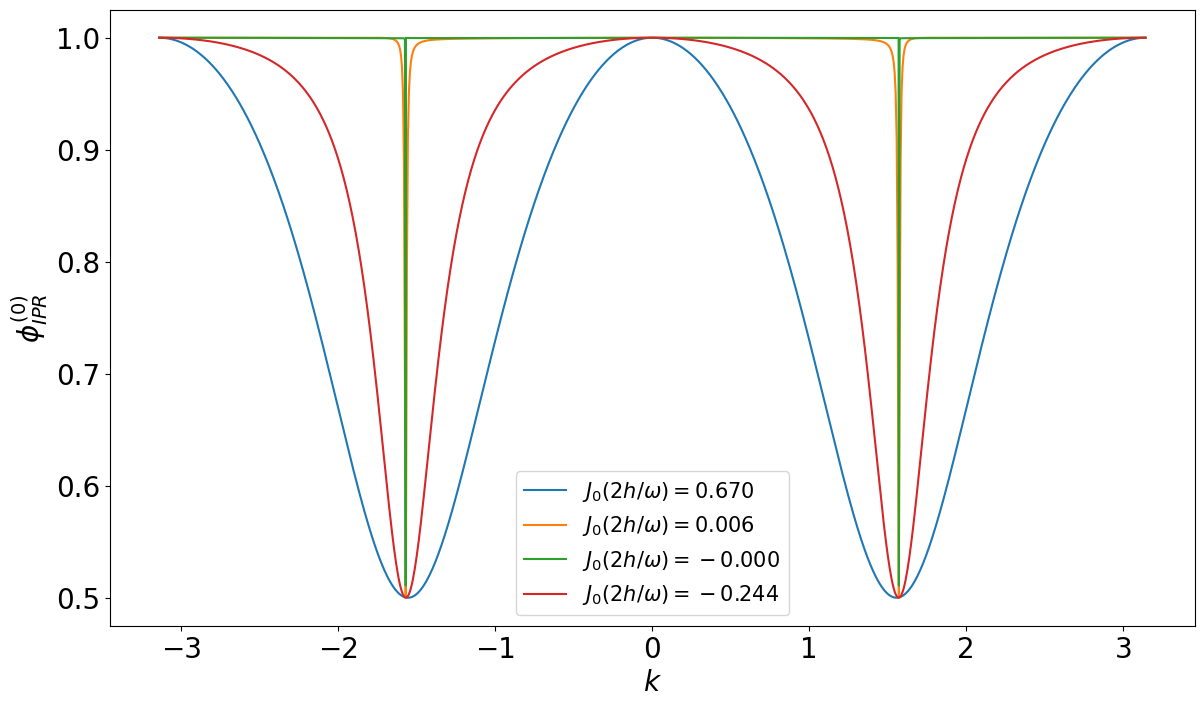

CPU times: user 15.2 s, sys: 623 ms, total: 15.8 s
Wall time: 15.3 s


In [116]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
from tqdm import tqdm
import traceback

plt.rcParams.update({
    "figure.figsize": (14, 8),
    "text.usetex": False,
    "font.size": 20})

freezing_pts = jn_zeros(0, 5)
max_pts = jn_zeros(1,5)

#
# set up the calculation
#
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2
hmed = 0.995 * omega * freezing_pts/2
hmax = 1.25 * omega * max_pts/2
hfin = 0.5 * omega * freezing_pts/2


delta = 1e-4
fbz = np.linspace(-np.pi+delta, np.pi-delta, 1000)
aa = [-np.pi/2.0,np.pi/2.0]
fbz = np.sort(np.append(fbz,aa))

for h in np.sort([hfrz[0], hmed[0], hmax[0], hfin[0]]):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    iprvals_exact = np.array([get_iprvals_exact(k, params, sort=True) for k in fbz])
    plt.plot(fbz, iprvals_exact[:,0], label=fr"$J_0(2h/\omega)={j0(2*h/w):1.3f}$")

plt.ylabel(f'$\phi^{{({{0}})}}_{{IPR}}$')
plt.xlabel(r'$k$')
plt.legend(fontsize = 15)
plt.savefig('ising_exact.jpeg', dpi = 800)
plt.show()